# MILP optimization control with deep network transition

## Simple planning problem with continuous states
In this simple planning problem, we are going to show learning the model directly from realtime data stream and apply optimization on the model. The data will be generated from a simulator, which represent a 2D maze problem. 

Package installation

In [1]:
!pip --quiet install keras
!pip --quiet install h5py

Package imports

In [1]:
%matplotlib inline
import random
import os
import json
import sys
import string
import unicodedata
#Numpy and Scipy
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
from scipy.spatial import distance
#KERAS
from keras.layers import Dense, Activation,Dropout
from keras.models import Sequential
from keras.regularizers import l1,l2
from keras.models import load_model

Using TensorFlow backend.


## Data Generation Part
### 1. Maze problem domain simulator

Brief Discription of this domain simulator

1. Define a 2D maze, which allows agent move continously in this domain. 
2. Has one Goal state and one start state. 
3. Allows to define obstacles that agent cannot move in, or it will transfered to jail.
4. There is a jail location that outside maze domain.
5. Agent alive in deadend in the period of tolerate time steps


In [2]:
'''
Created on Oct 6, 2016

This class has two construction functions.
1. From data
2. From initial settings

Example of 2D maze setting

initial_setting = {
    "maze_bound"        : (0,0,10,10),             #Continous state bound
    "obstacles"         : [(1,1,3,3),(5,4,6,6.5)], #Some obstacles that never crosspassing
    "current_state"     : (0,0,0,1),               #Current State in X,Y and If in Jail
    "action_range"      : (-0.5,0.5),              #The effective action range
    "action_dim"        : 2,                       #Dimension of Actions
    "goal_state"        : (10,10,0,1),             #The goal state to finish running
    "jail_location"     : (-1,-1,1,0),             #Jain location
    "deadend_toleration": 2                        #How many step left after getting into jail
                   }
@author: wuga
'''

class DeterministicMaze(object):
    
    def __init__(self, setting):
        self.__dict__.update(setting)
        self.backup = setting
        self.X_AXIS = 0
        
    def Reset(self):
        backup=self.backup
        self.__dict__.update(backup)
        self.backup = backup
        self.X_AXIS = 0
    
    def UpdateState(self,new_state):
        self.current_state = new_state
        
    def Apply(self, action):
        if not self.current_state[2]:
            x_axis=self.current_state[0]
            y_axis=self.current_state[1]
            x_axis=self.current_state[0]+action[0]
            if x_axis>self.maze_bound[2]:
                x_axis=self.maze_bound[2]
            if x_axis<self.maze_bound[0]:
                x_axis=self.maze_bound[0]
            y_axis=self.current_state[1]+action[1]
            if y_axis>self.maze_bound[3]:
                y_axis=self.maze_bound[3]
            if y_axis<self.maze_bound[1]:
                y_axis=self.maze_bound[1]
            self.UpdateState((x_axis,y_axis,0,1))
            if self.Collision():
                self.UpdateState(self.jail_location)
        else:
            self.deadend_toleration=self.deadend_toleration-1
        return self.current_state
                
    def StateIn(self, area, position):
        if (position[0] >= area[0]) and (position[0] <= area[2]) and \
        (position[1] >= area[1]) and (position[1] <= area[3]):
            return True
        else:
            return False
                
    def Collision(self):
        for area in self.obstacles:
            if self.StateIn(area, self.current_state):
                return True
        return False
    
    def IfGameEnd(self):
        if (self.current_state[0] == self.goal_state[0]) and \
        (self.current_state[1] == self.goal_state[1]) and \
        (self.current_state[2] == self.goal_state[2]):
            #print 'Get goal state! system resetted'
            self.Reset()
        if (self.deadend_toleration == 0):
            self.Reset()
            
    def DeltaDistance(self,new_state,old_state):
        delta=[]
        delta.append(new_state[0]-old_state[0])
        delta.append(new_state[1]-old_state[1])
        if (new_state[2]==1):
            delta.append(1)
            delta.append(0)
        else:
            delta.append(0)
            delta.append(1)
        return delta
    
    def GetCurrentState(self):
        return self.current_state

#### Simulator Test code
Please read the setting structure for creating maze.

This is an example of defining a maze

In [3]:
initial_setting = {
    "maze_bound"        : (0,0,10,10),             #Continous state bound
    "obstacles"         : [(1,1,3,3),(5,4,6,6.5)], #Some obstacles that never crosspassing
    "current_state"     : (0,0,0,1),               #Current State in X,Y and If in Jail
    "action_range"      : (-0.5,0.5),              #The effective action range
    "goal_state"        : (10,10,0,1),             #The goal state to finish running
    "jail_location"     : (-1,-1,1,0),             #Jain location
    "deadend_toleration": 2,                       #How many step left after getting into jail
    "action_dim"        : 2                        #Dimension of Actions    
    }

# Maze=DeterministicMaze(initial_setting)
# print Maze.current_state
# action1=(0,11)
# Maze.Apply(action1)
# action2=(1,10)
# Maze.Apply(action2)
# print Maze.current_state

#### Supporting Functions

In [4]:
#Given local path, find full path
def PathFinder(path):
    script_dir = os.path.dirname('__file__')
    fullpath = os.path.join(script_dir,path)
    return fullpath

#Read Data for Deep Learning
def ReadData(path):
    fullpath=PathFinder(path)
    return genfromtxt(fullpath, delimiter=',')

### 2. Planner
This planner is a random walker, who will explore the maze randomly. This is just for generate more random data to support transition function training. 

In [7]:
class RandomWalk(object):
    def __init__(self, actiondim, ranges):
        self.ranges=ranges
        self.actiondim=actiondim
    
    def Go(self):
        stride=[]
        for i in range(self.actiondim):
            stride.append(random.triangular(self.ranges[0],self.ranges[1], 0.2))
        print(stride)
        return stride

In [8]:
Maze=DeterministicMaze(initial_setting)
Planner=RandomWalk(Maze.action_dim,Maze.action_range)
for i in range(10):
    Planner.Go()

[0.29548295734721075, -0.09953835599827948]
[0.2343131755970833, 0.006440117158830194]
[0.063882072237336, -0.008456109432780468]
[0.07405381245778797, 0.17091932196633763]
[0.15425578648865457, 0.4668316583708877]
[0.49417665599865557, -0.09006689730375012]
[-0.14978309147421304, -0.08380074468792093]
[-0.06324341010717982, 0.011419607177964308]
[-0.11973324307121214, -0.06629948872066194]
[-0.15196040593233384, 0.20270571508047225]


### 3. Data writter
This class combine the simulator and planner to generate some routing data from multiple tries. 

In [9]:
class DataGenerator(object):
    def __init__(self, model):
            self.maze=model
            self.planner=RandomWalk(self.maze.action_dim,self.maze.action_range)
            
    def WriteData(self,size,datapath,labelpath):
        fulldatapath=PathFinder(datapath)
        fulllabelpath=PathFinder(labelpath)
        datafile = open(fulldatapath,'w')
        labelfile = open(fulllabelpath,'w')
        for i in range(0,size):
            self.maze.IfGameEnd()
            action=self.planner.Go()
            old_state=Maze.GetCurrentState()
            self.maze.Apply(action)
            new_state=self.maze.GetCurrentState()
            Data=list(old_state)+action
            #Label=list(new_state)
            Label=self.maze.DeltaDistance(new_state,old_state)
            datafile.write(','.join(map(str, Data))+'\n')
            labelfile.write(','.join(map(str, Label))+'\n')
        datafile.close()
        labelfile.close()

#### Call above classes!

In [10]:
Maze=DeterministicMaze(initial_setting)
Generator=DataGenerator(Maze)
Datapath="StateActionData.txt"
Labelpath="StateActionLabel.txt"
Generator.WriteData(100000,Datapath,Labelpath)

[-0.25122780149264223, 0.13543653216291462]
[0.2081569795300272, 0.23427546813450745]
[0.152412469672346, -0.15566763157736047]
[-0.19943716704285813, -0.0662473887501886]
[0.040956809482770806, 0.2925882439388001]
[-0.09160117205650042, 0.329465802180682]
[-0.03573429531446187, 0.2607263450752799]
[-0.011533987243405597, 0.014899536676026282]
[-0.11090127516076492, -0.056911506170750026]
[-0.16668436458788005, 0.1747795078387987]
[-0.04757184785267371, -0.02334942488037267]
[0.3115709418709377, 0.061566757348286316]
[0.16006526980939217, -0.1352292069454668]
[0.11719534321836267, 0.1679499321106298]
[0.03311634037625233, 0.1946321054830582]
[0.15050153606893735, 0.2032157281506653]
[0.05761483329504613, 0.29836310879005]
[0.14754051672686774, 0.0501651329589351]
[0.10427866128554686, -0.13127968722050193]
[0.1968214923583006, -0.16929480652825896]
[-0.05064947674468617, -0.2697146083286155]
[0.026560461650458334, 0.12029075473643858]
[0.1868019029296173, 0.18562233453635535]
[0.094777

[0.24116715339291123, 0.2812048484711038]
[0.3533456435583489, -0.3442987121314384]
[0.26916773633717866, -0.02896742798415458]
[0.02997733749345055, 0.18043831460763526]
[0.10671774972809045, -0.25921744790413487]
[0.0668844044187501, 0.19845681591194753]
[0.20285028007871486, 0.02866242450378198]
[0.32628456442202025, 0.11441506080263697]
[-0.06895544773287493, -0.05095023874091964]
[-0.41261630929536863, 0.10867040504819447]
[0.19514083859300302, 0.21182569056355216]
[0.2954119206716256, 0.16351851100697323]
[0.10475382248604992, 0.33124374781370614]
[-0.1692026837768218, -0.26206272830035127]
[-0.1494086625482195, 0.11289945132138435]
[0.2581626687694948, 0.013023556350097554]
[-0.028035163153940335, 0.4083672904958225]
[-0.04409230607040038, 0.1697890194252658]
[0.30404039805969546, -0.14891447036257277]
[0.08362225398211154, 0.2531575663313368]
[-0.26140768789205493, -0.007626440358366238]
[-0.2865766674799935, -0.1230370340533572]
[-0.09806759867311626, 0.000588418382618805]
[0.

[0.21268803699636918, 0.018999724216781422]
[0.10269370591323834, -0.2186618737465979]
[0.20593499456862785, -0.10580822365996573]
[-0.33399199174710226, -0.20834925554970407]
[0.24534263012110613, -0.04299872048750625]
[0.3614354916400734, -0.0002570287341835398]
[-0.2459933681013498, 0.21576730229982893]
[0.025657701529021137, 0.06976386155893377]
[0.009876449605146775, 0.13438257128402165]
[0.00778594632049312, 0.3373143628324918]
[0.21929777967835373, 0.2195032188054949]
[0.45965652688285935, -0.2612419367517662]
[-0.06409004623003028, 0.16083838014854457]
[0.1891812488293192, 0.2952623174272838]
[-0.09566866887883846, -0.323383832167663]
[0.09773368655119763, 0.14728983409525875]
[-0.07401858403097605, 0.2029774525625075]
[0.3687535595207799, -0.144956992338363]
[0.05561250323286537, -0.06915941162554146]
[0.3980392514926386, 0.09768020881018835]
[0.11570759436955191, 0.10819363386609082]
[0.027542563975745282, 0.08970561215883899]
[0.06437208838926856, 0.19916049550446602]
[-0.22

[0.41707798905857696, 0.037877592193436116]
[-0.454555303269852, -0.3669590088885717]
[0.07930537821174799, -0.3738682496246902]
[0.16626155285968824, 0.1908525706255111]
[0.42431292632142825, 0.32955746295486293]
[0.11212052221575808, 0.004435688820362826]
[-0.0845450777558906, -0.10619851043935452]
[-0.06094513197569085, -0.043119195129715626]
[-0.1396274605279938, 0.2571460713570335]
[-0.056545512956903354, 0.1629374259453027]
[0.163604432886166, 0.2051440933851686]
[-0.008618317830302535, 0.27610717163317977]
[0.21877611599405983, -0.4114946775331778]
[-0.23989376643142563, 0.06855979534793133]
[0.22902553571981088, 0.10925302276548166]
[0.3459978650538499, -0.19452312125361304]
[0.17037369866603025, -0.2896024219527956]
[-0.12097826734447137, 0.2694122082112025]
[-0.19782384981179324, -0.12330188536901421]
[-0.28617993213489296, 0.3337931353739937]
[0.1867184927966724, -0.020300051751575343]
[-0.08553081345559682, -0.14922282327707315]
[-0.03426287563194924, 0.3669624387964352]
[0

[0.01629012175115474, 0.36949230087224316]
[0.144039484676023, 0.12664468141462004]
[0.14595354517941006, 0.08878478449519212]
[0.18212164215380933, 0.3768259493338346]
[0.3316990671897575, -0.2423318277175528]
[0.405589882770199, 0.18759824210376697]
[0.09222867891827524, 0.013159211072479637]
[0.1588351123689823, -0.2261573260363824]
[-0.0250031411500512, -0.06916924296430155]
[-0.16717936522975402, 0.23687890910029374]
[0.21075931792655556, 0.20730529610649656]
[-0.1271806145896302, 0.15474072938507855]
[0.08147606636976534, -0.4183907719547326]
[0.020822963207026368, 0.25287805564931665]
[-0.4015106940986459, 0.3373003435677715]
[0.08822527071346997, 0.17825875610816166]
[-0.15853974596249887, 0.17310102718929787]
[0.33186090281727865, 0.09292799096318183]
[0.20367505116399665, 0.3143978132223775]
[0.1596645751685669, 0.28336227408443704]
[-0.17462814358654488, 0.2702240505821598]
[0.3389952883752181, 0.14826621887580982]
[0.14388686704477072, 0.19425372161808463]
[-0.0881930860425

[0.39030186450958937, -0.07056483278191328]
[0.30776398689237533, -0.033572852007281384]
[-0.21414093685746655, 0.15280945200232376]
[0.10475365125898084, 0.306792673209012]
[0.12157609384110935, -0.015507745034377629]
[0.15294281759101713, 0.23371565077183476]
[-0.03331912725136282, -0.08707837812670216]
[-0.00492683949493572, -0.32298733209660513]
[-0.3354447519336506, 0.07046798684355138]
[0.20245387459735686, -0.032994888689271695]
[0.180755281568321, 0.18730972488152287]
[-0.05290060494754123, 0.17573227192783492]
[0.2187492184751621, 0.13105639338817043]
[-0.341037096983247, -0.022525768198957963]
[0.41275007584097156, 0.16518026831869348]
[0.2205989567687685, -0.2632917412399486]
[-0.044008182332128276, -0.3493772053659404]
[0.2726291029853951, 0.3202270640924748]
[0.13921767782404393, 0.2919856737885996]
[0.023380297137700068, -0.17869685392035173]
[0.37295754426779254, 0.3321949278118859]
[-0.24554010055207226, 0.3622716261970831]
[-0.34807328952025307, 0.3049553728565574]
[0.

[-0.11557271375451666, 0.19634916091429444]
[0.16144700463191874, 0.31029455958520735]
[-0.2568463281068981, 0.31492830145591016]
[-0.44335727202480624, -0.19702973803246254]
[0.3480382618197684, -0.019367471160143812]
[-0.37129064871673806, 0.1260779124549677]
[0.27322338562232196, -0.17499956619206936]
[0.07413198407971244, 0.41514779440249305]
[-0.043900908402221384, -0.06728013223443391]
[0.40985238109375843, 0.0013090138657059214]
[0.27413966896381026, -0.09117722619626223]
[0.26412812475410274, 0.2783462601371929]
[0.38613745492495816, -0.38907144207466027]
[0.20417473352490012, -0.13737943000956448]
[-0.21603436344325538, 0.2680660710382351]
[0.09187969278586072, -0.05434001868910343]
[0.3223113228728967, 0.37014531968019615]
[0.2842441309861949, -0.13075265851722773]
[0.1856115661047324, 0.1130484244801443]
[-0.19925042553515399, 0.33366687135672624]
[-0.3852886233632271, -0.03424886391089205]
[-0.47252207487685205, -0.32345599059983987]
[-0.0499781867922095, 0.1240678957243166

[-0.3222244668795108, -0.13238676835307983]
[0.013487294911100123, 0.3099966193846562]
[-0.34455797990407366, 0.07797256056485069]
[0.31679298741522344, -0.023278824387312713]
[0.023180413756460294, 0.2162139187857613]
[0.4299616130956497, 0.11945520935705467]
[-0.014174301705970782, -0.40615756139368747]
[0.037110889501682176, 0.09265326403499508]
[0.12426027119191829, -0.15084756145936584]
[-0.17314570042233163, 0.08124955152973523]
[-0.22831116911733218, 0.17005585894885267]
[-0.15633984297551384, -0.4264999264030335]
[-0.2082478755331995, -0.1312894644678671]
[-0.16985515541896817, 0.1598731733440334]
[0.20062769595128038, 0.06450576868243596]
[0.18403706331919456, 0.11268821380522565]
[0.32415673520368793, 0.24192817683051476]
[-0.2819959355453018, 0.23163350978136743]
[0.16347964669821902, 0.19291337320051993]
[0.2984900041772073, -0.024014228574576524]
[-0.27995552390093315, 0.31194737002063966]
[0.2048714327851821, 0.25650948206638413]
[0.006545063599454948, 0.21406834448537676

[0.3547918167738253, 0.3106241896393245]
[-0.22203932151073996, 0.1529291934080247]
[-0.2162452692377107, -0.03423335574957642]
[0.07369730943634611, -0.03182337759578446]
[-0.35339409528703625, 0.30441414378878995]
[0.20484813472186036, 0.14540228860084825]
[0.18532316261458537, -0.1634734516133483]
[0.244886578284302, -0.032796538323570434]
[0.03597896302581027, -0.06212768798463553]
[0.28214904532857554, 0.02281672532191903]
[-0.31936745511343856, 0.3515037589507302]
[0.20098845387782827, -0.0769441824964438]
[0.40551428100983145, 0.07535943844117132]
[-0.16135414552557542, 0.11886404162435305]
[-0.22142347593309825, -0.04292589826217502]
[-0.10068510365293104, 0.09704891497877433]
[0.24906948882882107, -0.08277270217900146]
[0.28812735211098384, -0.18641994755751756]
[-0.12278834215351547, 0.13129643959609505]
[0.0025548682023875946, 0.08128516967691612]
[0.16127227547557876, -0.06121701207704633]
[0.3290328858145226, 0.04626537108723794]
[0.19737704740564788, 0.11915410968955165]


[-0.13235622108588735, 0.03992590191949352]
[-0.05735893550711574, 0.030263583133468663]
[-0.4125987691623953, -0.015505196095294438]
[0.11111075992699226, 0.17630977230695544]
[0.1781576250420287, 0.19495622379754862]
[-0.004269492724075508, 0.13440573213631513]
[0.301410529569044, 0.24289268642810918]
[0.29184008679146584, -0.05879492737822223]
[-0.27727530449381355, 0.11664912069611055]
[-0.21875943335261677, 0.1752787449211599]
[0.2594066653911684, 0.15405968081653354]
[0.05162002140882671, -0.0003907622467682059]
[0.1828842514546064, -0.1581322524494443]
[-0.05833190329827426, 0.05985815561684493]
[-0.0931154593560003, -0.11092726080714688]
[0.3432086242174788, -0.3277826435783614]
[-0.060404991657901974, 0.02305045224049518]
[0.08340834644708583, -0.2470032825088535]
[0.06425067259670592, 0.02022538237236149]
[0.13921918770912, 0.10139270561209712]
[-0.03108886198927252, 0.11351053715942783]
[0.27377201975105936, 0.005866625619196819]
[0.08988447251540677, 0.2646358772171389]
[0.

[0.03571160323404454, 0.053003771541796696]
[0.21532387011197063, 0.22675523493068728]
[0.41103798667088054, 0.12323528311893361]
[0.19826444538087096, -0.3753515713859805]
[0.04888887866724212, 0.002523020488785721]
[0.05613447594152976, -0.09222317164627186]
[0.44112177074482856, 0.2955321743778536]
[0.07096204404528617, 0.3066015873795791]
[-0.10956701977366379, -0.06422242236905196]
[0.1999768835912823, 0.3390785324121557]
[0.3963702430603292, -0.03576272220813009]
[-0.24127492968828312, 0.24608830413628818]
[-0.03464675429616759, 0.26854932491773664]
[0.1649822948816152, 0.2500991159981758]
[0.16610028382463193, 0.21486028339319835]
[-0.11361691590543138, -0.14460358679565039]
[0.11506215785775087, 0.10813998195642838]
[-0.02370509937752574, 0.07465361853280295]
[0.22688643704076494, 0.1272476472873768]
[-0.2761035500073783, -0.01001960969570237]
[0.1405929028742634, 0.09496286451484914]
[0.1274561236677778, -0.4891830852758585]
[0.25899012024855994, 0.09703134673672542]
[0.372904

[0.2585555766480606, -0.0015195114791065056]
[0.019317753554211725, 0.23870493796108405]
[0.188694074352731, 0.012958410655352859]
[0.2762543260130909, -0.20946655573041556]
[-0.023399112878254746, -0.16704218531635534]
[0.06187018060934546, 0.4181718962876174]
[0.2143222289957834, 0.1533531602162752]
[0.10795444338441562, 0.3154133887158651]
[-0.032652607811883005, 0.20470234834428547]
[-0.021279304135356725, 0.18349637452557954]
[-0.09681956334399561, -0.06478516497271447]
[-0.10051884993601717, -0.04327852587759573]
[-0.26071723472908337, 0.22435719304696666]
[-0.31471564213732145, 0.302387718991345]
[-0.18358545639123636, 0.16663537544482288]
[0.12726774161356325, 0.15454269595634318]
[0.008180178014856598, 0.2575107793428102]
[-0.14700065220142516, 0.18713540540073936]
[0.36192330991607025, -0.17198592040384614]
[-0.2766266179163893, 0.29108579012314517]
[-0.09798973614325213, -0.18184284122030725]
[0.4022723706137431, 0.2640460507208202]
[0.17184321239174338, -0.00675767611327293

[-0.11203524118967012, 0.2580868006899327]
[0.2963831251979048, 0.27966675774959315]
[0.35429926586940963, 0.41858856470650374]
[0.03806349606523862, 0.28751014577627326]
[-0.28467848490679626, -0.28751899060538855]
[0.07178094631481335, 0.3930147384618883]
[-0.038816756344035475, 0.2728359217472122]
[0.22687000789752065, -0.10805162314831812]
[0.3919509469052552, 0.20863337531057363]
[0.377380124527363, 0.07444482322691603]
[0.1379646299604379, 0.17542099321461613]
[-0.12435231042850586, -0.0017309237931396049]
[0.3923440238671415, 0.28413218709117005]
[0.3756427308008786, -0.14784376387269887]
[-0.2776665689925366, 0.040268890482103914]
[0.04319535091852811, -0.13453774068148988]
[0.46311255525012046, -0.0632764184247605]
[-0.1100488357119433, -0.005170044363117632]
[0.15269818960134396, 0.22282564417667]
[-0.12753627191530864, 0.18205554771512744]
[0.16435401094152702, 0.03567875623246486]
[-0.1912881272237021, 0.07602880883653895]
[0.14072322505026202, -0.04213717739350237]
[-0.045

[-0.0976089505521775, 0.06606559270633339]
[0.3044784422293927, 0.08718403112165551]
[-0.3775900737524144, 0.1950572851316651]
[-0.20705654044791105, -0.13472510651735947]
[0.11282235551701147, -0.24996119542612844]
[0.2673474058806335, 0.31116208615331603]
[-0.3490525272355663, 0.3285490715737772]
[-0.23517168995652227, 0.20996266158556554]
[0.22033281121002435, 0.1241641551540642]
[0.005175217707987123, 0.3917088286008332]
[0.0936097560977246, 0.3161397000369677]
[-0.26293069551904136, -0.3748115691866666]
[0.29450816689182113, 0.06760073682934364]
[-0.3831590224390281, -0.08548026494761773]
[0.2145093570436919, -0.3743814614635481]
[-0.26955997488199135, 0.287028210770929]
[-0.28566680752473295, 0.2205910656050763]
[0.2538627338900995, -0.05985412512367311]
[-0.07581062362518931, 0.1376301795385747]
[0.34413412655251524, 0.2368130063372083]
[0.05820441268841958, -0.15367179182265672]
[-0.12752324450388475, -0.09810590754949855]
[-0.07755650118697632, 0.3834130962980235]
[-0.31365276

[-0.05610531503006588, -0.045068090592665644]
[-0.412386094239677, 0.32358434176307316]
[-0.1866489327685379, 0.23857332656130076]
[-0.17750490187382467, -0.029502846145440575]
[-0.07479250957241235, 0.09093388449558548]
[0.09016271344988425, -0.18537333598093358]
[-0.08882704060003138, 0.2598995747418721]
[0.22092621498637283, 0.04476503222130779]
[0.1708337924982588, 0.22815538133452934]
[0.12968627982206504, 0.09863738300527336]
[0.25516970003153555, 0.05566975672677765]
[0.042025971819282915, -0.09841400391940563]
[-0.052302857968108574, -0.010951845641172964]
[0.18730140328647582, 0.17889884230833286]
[-0.40464860423845556, 0.16551746474964824]
[0.0056041352721707405, 0.18418222069145584]
[-0.22043985425927254, 0.13396477754919534]
[0.07619005619158403, 0.06882775071647806]
[0.27298029483568487, -0.06941014908169851]
[0.02430435148577137, 0.057477992237073394]
[-0.04853082951896592, 0.1337315726701882]
[-0.4446176690279871, -0.10053246523787468]
[0.1973745900961109, -0.41801810471

[-0.1427002282010345, -0.10805654365949113]
[-0.042464462125729296, 0.06514066438696431]
[0.16366924576795194, 0.2766250255947851]
[0.21426094905659898, 0.2239349039316485]
[0.371027601585312, -0.2352010355386958]
[0.08232896410568602, -0.12936980220142302]
[0.16760318425268028, 0.1312204079596424]
[-0.08502520547112014, 0.2584360321287501]
[0.10431475345108199, -0.29855074547448124]
[0.18878073710836174, 0.30662382011023637]
[-0.2229949281774724, 0.07336478729774376]
[0.027282667400869043, -0.07383483772386923]
[-0.07602922189013184, 0.3108768280557458]
[0.01299008509591959, -0.17031928889877762]
[0.26248979739920053, 0.12475947770547069]
[-0.20497635013050902, 0.30984666178661047]
[0.3336097188467001, 0.15445886452971969]
[0.08056068151108953, 0.3472646725957621]
[0.15757969439911723, 0.23129163124268476]
[-0.3077314893964882, -0.23676091028727558]
[0.11571895668238696, -0.2140813734786861]
[-0.0677420405313926, 0.36894067693863897]
[0.31152488178837684, -0.09189537740738657]
[-0.278

[0.0748829923503379, 0.10197841111692774]
[0.22206218310203069, 0.2218558901477085]
[-0.04655770480801774, 0.1619195770551477]
[0.030231734248435727, 0.22564153031531853]
[0.04075109777395769, 0.15967599768486063]
[0.03240848923410866, -0.109544590627556]
[-0.04550016646137528, 0.27378201045969663]
[0.22656827793109663, -0.003874207939658314]
[-0.020800906246555673, 0.3442114651633631]
[0.3904800229551923, 0.01315849739719277]
[-0.08599832914652872, -0.05163987899140843]
[0.26897367744423517, -0.3871561900499869]
[-0.06769960070088654, 0.2368161067341807]
[0.21730832647650844, 0.11385098248474135]
[0.0227555673569233, 0.09988681055682747]
[0.16588275771891225, 0.32074936777973934]
[-0.20142697810283267, 0.3752790075240924]
[0.1874142537444451, 0.10198236030053276]
[0.26530913207298645, 0.3560977121310057]
[0.47951539214656064, 0.3355012854961514]
[0.22080611277983492, 0.020423976377244024]
[0.09766185461382637, 0.17475875159895204]
[-0.0017662418329189022, -0.02256495097825345]
[0.2660

[0.2860864869484252, 0.19984346622624072]
[0.16045303902751296, -0.24134770289655738]
[0.008517302684546979, 0.14731039725442407]
[-0.07672817199900006, -0.3226880163403414]
[0.15182004447268915, -0.053698101985037106]
[0.02589049593864101, -0.18345206915411327]
[-0.10162627260292123, 0.4314348123051831]
[0.0796323482039969, 0.006198702902104891]
[0.011664037010975625, 0.17898675450616408]
[-0.08201782654685186, 0.17023344359989045]
[-0.19387721297261118, -0.1264362062019898]
[0.10129391369731888, -0.21893205016483092]
[0.0640417418591015, -0.10555749630743916]
[-0.1580606974732613, 0.10417985131860652]
[-0.2698499745203117, 0.0011163491754159205]
[-0.21476140192930754, 0.21579618776450227]
[0.12991632724476354, 0.32677146701508275]
[0.021038744463555914, 0.06758717460491204]
[-0.2793142028228514, 0.18555656600894888]
[0.08209835624446216, -0.17317248225392495]
[0.201191070966531, 0.2330492230751383]
[0.012244998609301505, 0.15429034807861108]
[0.005193702558968338, 0.10137856881764018

[0.22546114260346606, 0.31545738958272546]
[0.44282714339232393, -0.05592835236336119]
[0.07554051277259655, -0.025133681427719823]
[0.08426387395918356, -0.2517077068990327]
[0.08380101955797004, 0.16951348577399128]
[0.12393188608784844, 0.2355461422341537]
[0.23883769876846478, 0.11229330488014522]
[0.13563625656476108, 0.303352311113705]
[0.03169545770684168, 0.30396131395096637]
[-0.38491420351515215, -0.003420180983664145]
[0.4715601079476839, 0.25322260729907425]
[0.12927890321113478, 0.15714673824774772]
[0.273058896881361, 0.2087768356790749]
[0.18156009383579153, 0.41523808955419766]
[0.4350030865958955, 0.26741310458275364]
[0.06073323581931933, 0.1774583359569919]
[0.3675320409507805, 0.14145352101233866]
[-0.3775527174788673, 0.10337561584567223]
[0.30327184541689944, -0.34970391664259415]
[-0.23336930551522167, -0.07354106339579697]
[0.07110456294293155, -0.004880666684103252]
[0.08219030633172442, 0.2811319900348726]
[0.031082561822433186, -0.17421209150474037]
[0.309198

[-0.06805637730082409, -0.4039482233922731]
[0.09379274522935754, -0.39748262174731774]
[-0.05385177638380245, 0.06061823806531008]
[0.24403412752020825, 0.019462899374274478]
[0.10410959322368063, 0.409465103628604]
[0.11616260670936396, 0.12954475666709153]
[0.3745235999086981, 0.3898803464993356]
[0.03525760179006099, 0.3335575317883768]
[0.08648245027328283, 0.052812614775455735]
[-0.1620672625091964, -0.08434560502148081]
[-0.23181234007704254, 0.1270223083157761]
[0.16494265387114604, 0.05964796447370102]
[0.23329041947361173, 0.06543758156401602]
[0.18447876035818545, 0.2016926350657552]
[0.15271125787438844, -0.22395741400666958]
[-0.16622270781491139, 0.08574805710503997]
[0.09459812991399452, 0.03553976622512245]
[-0.19725201603501957, 0.22343529978507026]
[0.33537860376873296, 0.21073569780418344]
[-0.027974479359288762, 0.3276888758984838]
[0.24609324042647884, -0.14322811335495594]
[0.3381082340401311, 0.11654136420566963]
[0.17000530490369803, 0.04441524546128384]
[0.0851

[0.21019556493849045, 0.08042478558045474]
[0.03960804040990884, 0.21353254713270003]
[0.24002358100155963, -0.029223162135857794]
[0.09239196394170923, 0.1627460512828628]
[0.2799817480046286, 0.1210609671859123]
[0.48683311463371787, -0.1447378192294534]
[0.09712717440862517, -0.09356699173373545]
[0.027173208468316612, -0.3858657747620513]
[0.34221707321410505, 0.40764805846090163]
[0.183494906839881, -0.17535587534541475]
[-0.13488407322494628, 0.3251051772442528]
[-0.24724355087266608, 0.2143828561948634]
[0.18845950034568582, -0.30239870962597604]
[0.20987562828725465, 0.17110162522850803]
[0.07007610342945769, 0.37329154472217196]
[0.1725987271484023, -0.04329237042849027]
[0.2551911030773094, -0.2404956014456951]
[-0.19257199684677068, -0.08530597060633227]
[0.16744083744654148, 0.25497192101352484]
[0.1965599082650621, 0.0575283475667433]
[-0.05561031427153734, -0.06131643099824602]
[-0.06110541457201202, 0.4328782085557595]
[-0.11409921386951172, 0.11673054104991365]
[0.22072

[-0.2039485083357555, -0.35929856999560106]
[0.38921303130438506, 0.3241013325477824]
[0.14933688643263332, 0.09685554523242335]
[-0.10067419712129855, 0.09341742700906086]
[0.26802690427365217, 0.09637698003464212]
[0.08087385609929554, 0.2884936662461529]
[-0.0858216859525755, 0.13733178599633555]
[-0.22160234484002406, 0.3869438569412741]
[0.19553549536238657, -0.24800348574041836]
[-0.1185857059224778, 0.047731510830513746]
[0.39457687968262284, 0.4130868263301098]
[-0.020664901624469545, -0.043174193717949394]
[0.4049082980684101, 0.26164974906770155]
[0.10964035028263297, 0.19943629120344308]
[0.38887525741215706, 0.2728192380563639]
[-0.08312825624144565, 0.1931395705148755]
[0.23220912769004853, -0.07410446250433861]
[-0.2466616617444956, 0.08352322152042935]
[-0.11188076888222803, 0.2996984301735436]
[-0.22158735512000027, -0.08207614288915688]
[0.2699327406829416, -0.10264160281098417]
[0.18547086022098502, -0.17785387790776502]
[0.19949417877088982, 0.22479461733234796]
[0.3

[-0.24526429194070998, 0.16116215592595984]
[0.3062844027800028, -0.15804009428000115]
[-0.1004207617892014, 0.19331004133173024]
[-0.03672123772545627, 0.13009866979442852]
[0.12339568467587936, 0.1598045608969807]
[-0.08193351110703911, 0.1662593478068447]
[-0.13267875254500477, 0.26816190946854523]
[0.3427989649190735, 0.30451165034043154]
[0.15966965052745896, 0.037443474498332185]
[-0.10969647622728829, -0.20944889427676172]
[-0.11853780255012214, 0.1781638534575386]
[0.12035205970643248, -0.05371812213579685]
[-0.26797908384594893, 0.07199663844643012]
[0.1525979749823152, 0.20850728678074504]
[-0.14050228535745007, 0.2907721397804412]
[-0.144667392840457, 0.22130336473642853]
[-0.04263518439803171, -0.2062833163681363]
[-0.041026671943657, -0.06607684279079046]
[-0.07009743544789121, 0.33501355338643807]
[0.33869442282451323, -0.34941403209566124]
[0.1294175959644872, 0.049897875779193135]
[0.15005921573937342, 0.29812950233009994]
[0.29895038250783595, -0.21791611540968214]
[0.

[-0.23584511163899302, 0.3828171574320511]
[0.03559078167812224, -0.4275681941173685]
[-0.3519816625121589, 0.09108182982233748]
[-0.34070522161913774, 0.11426069672626349]
[0.3872770320054464, -0.1302430438565253]
[0.026815777618457326, 0.16104403785054]
[0.12195480596121144, 0.15912385708660515]
[0.3263399039482991, 0.3556624832715387]
[0.36076876307188793, 0.2630174448342167]
[0.10636730244274017, 0.28285647728185725]
[0.06269837799387357, 0.1985894024840612]
[0.38476359944568367, -0.16020369270964663]
[0.148817642525776, -0.1476528568732876]
[0.17583993518147412, 0.16688671154250967]
[-0.15978594373882704, -0.31844655101654384]
[-0.3500067075264494, -0.06663094533487474]
[-0.07609365358314829, 0.31376169142441035]
[-0.11569845892085956, 0.004458730392157495]
[0.2603137951953646, 0.16778027333255263]
[-0.106554157192702, -0.16704518403960683]
[-0.08001906835966949, -0.07541831924995962]
[-0.0605784682985373, 0.2238046868723077]
[-0.15875184539860276, 0.14156022995516548]
[-0.1449637

[0.3258221858007945, 0.21217113099868323]
[0.29238776401296124, 0.27004421340063167]
[0.08356317232195187, 0.2795065134388385]
[0.054255625543246144, -0.012430681391772558]
[-0.03462015221338066, -0.03339343970178693]
[0.32493252862211697, 0.04163904220986847]
[-0.0055577995430887706, 0.147011692578919]
[-0.003853210787186423, 0.00815918415891459]
[-0.11154876458294682, 0.14760640838516503]
[0.15548784888396627, 0.2870992168247314]
[0.21838767016762856, 0.26836367102855896]
[-0.43855186856672174, 0.19763054548591996]
[-0.034358781673432204, 0.3492738125441449]
[-0.348892044101482, 0.19907608876995297]
[-0.23998646857288553, -0.3807969403481235]
[0.1929359666551833, 0.10742258410682926]
[-0.22668488072382326, -0.23218090589698231]
[0.4018685017927904, -0.14559419270294033]
[0.10819965642016005, -0.11254797098357372]
[0.20528841635664674, 0.2959585661901344]
[-0.17180099023440537, 0.008091722949621127]
[0.23231580085395337, 0.17249971908068762]
[0.16709501680146732, 0.17842001376952943]


[0.00027144975229753676, -0.007715675319502957]
[0.05002476120396526, 0.25433253645644033]
[0.4393411949143785, -0.34763233501056323]
[0.19765853623109453, 0.15055034563746195]
[-0.1364211654042196, -0.21054220743969082]
[0.32151375992960485, 0.16246503018716718]
[-0.29365134886820443, -0.29810583278578073]
[0.2911125063165141, -0.36709537723177377]
[0.20121285953678697, -0.11657493413304776]
[-0.2194540518591775, -0.08756558921755836]
[-0.1418838586018591, 0.2300165042719119]
[0.2887968720330165, 0.10318999887642122]
[0.25798761673293663, 0.08294425162704677]
[-0.19084160514669013, 0.4392943811824902]
[-0.15649202054632294, -0.05469965320501108]
[0.03400080529848293, 0.3426480500218648]
[0.4144047648747232, 0.14257497966017985]
[-0.20048230426026592, -0.06684515619805026]
[0.08544566985708024, 0.25796281732450677]
[0.4170435216821622, 0.2022246615362055]
[0.3044674335267058, 0.2521680788920527]
[-0.09591806733800184, 0.24138253126810283]
[0.09039899201965274, -0.3115784824826412]
[0.0

[0.15454442157439707, -0.11549971937976855]
[0.37421142677370056, -0.12602785776393133]
[0.17636092035626516, 0.29451987447833977]
[0.025151701374001023, 0.12400575135296099]
[0.20839657126565125, 0.14125623130967047]
[-0.15073820592432713, 0.3788295441417141]
[-0.3533466188816169, 0.11534486962119572]
[-0.31941231537743475, 0.28116346580658524]
[-0.004247849466173292, 0.20033535364086974]
[0.3905729831318221, 0.11385924605092335]
[0.2032018781580987, 0.4271982845342752]
[-0.12492913382418858, 0.3995394677846211]
[0.20460990710000954, 0.4613614721381011]
[0.1425534918638608, 0.2093803566227712]
[0.20322746483817555, -0.17076340477454838]
[-0.12191312445463831, -0.336173049485749]
[0.25332893336403106, -0.4885357552962]
[0.1897508792383087, -0.25757100196431276]
[0.33970005093989997, 0.42284988190731543]
[0.06155360484511441, 0.2757056698821692]
[0.20006904548561155, 0.38901380727373586]
[0.04826845243886746, 0.21875983730225962]
[-0.08378548035577132, 0.2147205535644508]
[-0.2393988334

[0.42827701583994937, -0.08843912284974265]
[0.23505345936423933, 0.05498985769453346]
[0.32500783738869166, 0.1188802381878391]
[0.009916717066785097, 0.02530755234012605]
[0.3138537699848014, -0.1712499338959661]
[0.16860419733665477, -0.40691448995635526]
[0.09660607988855041, 0.1126011848099594]
[-0.03289935341240635, 0.16957932635317285]
[0.07442553484913927, -0.08161038758153627]
[-0.1904573477572863, 0.43096874976799837]
[-0.09388290830539237, 0.21827400796977153]
[-0.09166951221475489, -0.2241300177667157]
[0.35081673299525096, 0.08273598890604916]
[-0.0901503270469366, 0.4033137910009815]
[-0.4232101519067522, 0.22902597919141104]
[-0.28326778338171565, 0.06636026662983963]
[0.011533640408831203, 0.25360589831777863]
[0.15275010433042635, 0.1871062184312886]
[-0.3682378254098757, 0.08668928375025253]
[-0.1775465140355667, 0.16216684065477316]
[0.24711106005388783, 0.31988054311660596]
[0.41574287177723734, -0.14132461958894127]
[0.3328230774529417, 0.35718170039945607]
[0.2797

[0.26543767808334157, -0.025673986260539017]
[0.15533231188405472, 0.3508734119416767]
[0.036639204624649535, 0.1746886970707947]
[0.01279946258168041, 0.22740154215502106]
[0.2650547191769232, 0.023491006353842603]
[-0.01631911887633619, -0.03906241643000807]
[0.19252929982744782, 0.015827330197905165]
[-0.22708710368543583, 0.04461065795165575]
[-0.07312375591993542, 0.21083901295555396]
[0.4528908825178898, 0.1498022994202164]
[0.09508091214929848, 0.2744321439055165]
[-0.035353065382828175, 0.22516802955849774]
[-0.26268395089050456, -0.1485994006227877]
[0.044450441336786994, 0.39335542386613664]
[0.12853690327654677, 0.0933424649238711]
[0.33685231226134293, -0.05737417641973752]
[0.027326912986954333, -0.0799803096853603]
[0.36987503105151853, 0.06344383832128153]
[-0.1563275318017761, 0.3277042628190176]
[0.3700907789546838, -0.14292745997391765]
[0.17940176279118458, 0.35581095498171394]
[-0.03647969152783781, -0.1371762261073135]
[-0.060215582697593306, 0.15518263474568927]
[

[-0.1349339411377049, 0.17393931321713008]
[-0.20967674928042912, -0.14501875428857847]
[-0.41258008957629244, 0.1720217035719167]
[-0.06898516966348678, 0.044007434389401134]
[-0.14155525599218693, 0.22480072616583763]
[0.37624947551264903, 0.3744354423411357]
[0.11657382827469032, 0.014111858244247988]
[-0.27754857065057137, 0.07720387630217607]
[-0.09825375248532309, 0.09277897460086981]
[0.3087765195921961, 0.4690956891716128]
[-0.19466134240644828, -0.294873304104875]
[0.3264048316159971, -0.1287354076485605]
[-0.25282122454678635, 0.4886764185343838]
[0.2918798795398122, -0.019853722258509343]
[0.00497085202470815, 0.1302408956530582]
[0.22905915133402593, 0.22862619590164912]
[-0.023156597417792746, 0.15756665461400854]
[-0.3377120141342128, -0.38794908686982876]
[0.25447765604661937, 0.2778377045059647]
[-0.18612779962925807, 0.01241044124079349]
[0.13331265044116591, 0.06750122742850662]
[0.25842729891045, -0.09606220997221476]
[0.21156235972668197, -0.415431160470165]
[-0.264

[-0.22399999979023277, 0.11443477654918066]
[0.2201668796041153, 0.2178229466426987]
[0.28724417454134066, 0.19642639078386992]
[0.1375549480636069, 0.21671007011682053]
[-0.3222668923536644, 0.23202801105083387]
[0.1677412956665254, -0.11637672571058932]
[-0.055473301861285684, 0.4352592579795116]
[0.43024996752559963, -0.0638383004803263]
[0.05693346335835636, -0.25911467776597696]
[0.07383282120158219, 0.33504500829223216]
[-0.015025717964486762, 0.29605559217537913]
[0.2864814255567654, 0.22788987814225126]
[0.24514372616755553, 0.4047521322359757]
[0.2034148668926754, 0.01761600722408163]
[-0.19803930695802768, 0.14654956478336967]
[0.1502480075782081, -0.004417910829500049]
[-0.18644679093401723, -0.0516622196460485]
[0.30716732762133403, -0.257352739509491]
[-0.4015112552094878, 0.3906503885392535]
[-0.2579876839773109, 0.2857847808699981]
[0.3889203425384085, -0.047288991738435426]
[0.01614312565802678, 0.34287006003706566]
[0.370202549468837, 0.08844347032918021]
[0.3543470244

[0.08160065718029441, 0.24559377899107093]
[0.1069010987199015, -0.2226159892152782]
[0.04704880216502194, -0.05319014890495549]
[-0.2970631926458417, -0.3790691317240532]
[-0.3568116830289381, 0.00866160506160829]
[0.19127779683302326, 0.3431340224178234]
[-0.02569220868430433, 0.4211457367299952]
[-0.06278767236591343, 0.06406353991630764]
[0.19243594984582812, 0.2099446621787569]
[0.18202539070220514, 0.28264108998367776]
[-0.021384697650123297, -0.039828295791444535]
[0.2603918091654517, -0.29274626668394277]
[-0.015849934310049774, -0.1649631245029486]
[0.2486912899150288, 0.4773278858098087]
[0.009229622596984233, -0.11093051128947029]
[0.48829863936144496, 0.20042234530910685]
[-0.23631580913566402, 0.07968937518728691]
[0.11337482957244693, 0.3892644990506233]
[0.26925161924544866, 0.0982215861665201]
[0.056578845998257465, -0.3840376582499452]
[0.355562637428656, -0.43660624212154997]
[0.10873282873352552, 0.13231471491487012]
[0.18413109732914779, 0.02339748198484115]
[0.3383

[0.3381047342378871, -0.2928106864875965]
[-0.010576607880813216, 0.12173491969056505]
[0.05027941638161393, 0.14215114009379004]
[0.22924778276670765, -0.24471691995547196]
[0.2238910864951174, 0.262361867000687]
[0.045376970313901754, -0.31973953813316125]
[0.28980743290265987, 0.17048289998216948]
[0.44475137206495197, -0.07004376420918168]
[-0.1743906926563193, 0.11835321095606799]
[-0.05156746530766376, -0.07795446997677746]
[-0.052333864722480194, 0.23027412394007357]
[0.15640381283492788, -0.17611551537794312]
[0.06118869000727334, 0.2703249853196319]
[-0.1665265533576522, 0.030020144447331476]
[0.17013101209078707, 0.01366727735085882]
[0.31718913451089703, 0.210195186493637]
[0.18413038488071798, -0.34903287519019266]
[0.2362168249793516, -0.1861088031364349]
[0.04306546782084175, 0.1627253010096571]
[-0.17011490473118668, 0.23959567042140262]
[0.26399217054907487, -0.02638038219123262]
[0.292060933154607, 0.14506711069724454]
[0.21032827547209693, 0.09541482980491989]
[-0.154

[0.1385774895891838, 0.4484597973034049]
[-0.2220910435777087, 0.3093971750805613]
[0.18832827522715045, 0.09263448783263528]
[0.21924418991089129, 0.2869296384374844]
[0.2199189195447923, -0.30902811034379574]
[-0.2465257243788324, -0.16151026868251844]
[-0.007833249304498358, 0.18486108568157278]
[0.2684122897439336, 0.22988492750147405]
[0.027451370946001585, 0.35441546737507956]
[0.22066987746447558, 0.24863926557715632]
[-0.29732356211584765, 0.10152927159987313]
[0.06231664170688078, 0.3532921767083276]
[-0.18076764980577315, -0.3208195510647128]
[-0.018411344498263482, 0.4005639392468158]
[0.3115269803537998, -0.07772398829493576]
[-0.14947358853045906, 0.33260011272607726]
[-0.11807020520843964, 0.28792696639625215]
[-0.01672775059110032, 0.1024597533316266]
[0.06446187026814454, 0.2829486284536582]
[0.24977641984689763, -0.24526364294840436]
[0.007670695496681312, 0.24040429000762353]
[-0.1719650301320791, 0.2273354306896591]
[0.06514130368259308, 0.3594797307824402]
[0.390556

[-0.049723562630061335, 0.109184374053511]
[0.24180030201657637, 0.18360189647796532]
[-0.1041642505766383, -0.06233331776604789]
[0.3828687866195185, -0.2792977272121755]
[-0.20904887754050272, 0.03711838467773232]
[0.17379012874789568, 0.0781047925509174]
[0.46061690878229944, 0.13000855090247876]
[-0.04962600598133732, 0.023349570672646536]
[-0.027378289770881747, -0.14202435651484807]
[0.03887057985397868, -0.2295437827162215]
[0.12592329459101892, 0.07650787366434386]
[-0.13261333338073827, 0.1668367200491805]
[0.049865098505641914, 0.1948038192866275]
[0.12185462557241311, -0.21672812486165682]
[0.016279162049657292, 0.2975199055141755]
[-0.25029880613453437, 0.26898488773710927]
[0.252335265105309, -0.4067828438802614]
[0.07073739322929906, 0.36494461230233377]
[-0.07560101682118797, 0.17387006631963697]
[0.28391751628481277, 0.2203483122219253]
[0.07739079513827773, -0.09873180248380697]
[0.26058654511014734, 0.257370720254258]
[0.06944348575591008, 0.20678361317386018]
[0.1262

[0.20738120265047838, -0.14258933223228165]
[-0.12916561172589697, 0.29047796131975023]
[0.17798159736394792, -0.06946598611330096]
[-0.04487371726674133, 0.41429155576728816]
[0.38162318831040853, 0.01497425480779302]
[-0.29591968673517943, 0.12383251302553167]
[0.18499254862485537, -0.030379157266617274]
[0.12100579714892501, 0.20699801923894406]
[-0.35588437750293045, 0.2966566186248577]
[-0.36711348463942783, -0.05532938461017983]
[0.21479428731906952, -0.17258044903726122]
[-0.01705053695565223, 0.12584352828523915]
[-0.06627007464424634, 0.11337801662701208]
[0.0739942543132569, 0.33906625598403906]
[0.2455234071090171, -0.25038045991079827]
[-0.09185349052223873, 0.1132081026516375]
[0.23195718036463914, 0.19261284098044418]
[0.012776971552368344, 0.4161760282406832]
[-0.259444676259991, -0.21449292925220548]
[0.1374405055642406, -0.1354150133926978]
[0.31316710496785716, 0.07321501115572082]
[-0.011285486424768731, 0.14535741534020896]
[-0.11210304075660488, 0.2100502705959264]

[-0.24405458829060012, 0.2888692024989393]
[0.22874876249590653, 0.2957393008204325]
[0.06838584832026973, -0.125722925081517]
[0.07906568820519266, 0.03084858218750397]
[-0.009402150182971025, 0.4585320645927393]
[0.3620002849010962, -0.2508817558259022]
[-0.04595340828808314, 0.23782762964535148]
[0.20861826321820487, 0.009074504809812756]
[-0.10765022383249467, 0.3131268647340195]
[-0.44421765762154275, 0.042293673329909076]
[0.15031198238543053, -0.0567164800483248]
[0.05122970239549174, 0.3562332363378828]
[0.1326592417974568, 0.020647858621167248]
[0.45848284812727474, -0.37072505612044304]
[0.12583062995677075, -0.20970471922770828]
[-0.09809426380479136, -0.2597965314340883]
[0.2705102843202244, 0.2113851060916565]
[0.20577003231004004, -0.06921958021372282]
[0.10781029642043904, 0.2015442274948423]
[0.21415793779800413, 0.24124757648382134]
[-0.1239950204652891, 0.1837578822223589]
[0.07911245599759675, -0.1851531689816781]
[0.12919605541872925, -0.056588606816784015]
[0.34164

[0.08886576655631073, -0.026058774016570363]
[0.08710601527266637, -0.16884157573954073]
[-0.3343097868933962, 0.24657843406018304]
[-0.23294620612549477, -0.229196820676407]
[0.1478564633238788, 0.027584390967492878]
[0.23690387058122275, 0.03192278531031345]
[0.10767993762208483, 0.35548964194485283]
[0.29316770655090385, 0.24027310363800103]
[0.28169219166846543, 0.08967335731963244]
[0.1237152672306624, -0.39786605825810123]
[0.2589090253834978, 0.2514434195298134]
[-0.3053256089641387, -0.002539153031379471]
[-0.08841048442105925, 0.15112457086829956]
[0.17354665093858224, -0.26403843687320727]
[0.21805514204416504, 0.04858343532404641]
[-0.05366289275921787, 0.2323596438873815]
[0.3076749451267521, -0.43779061714840933]
[0.3676078318595492, 0.12331917278309712]
[-0.4351844285246881, 0.3611764147893523]
[-0.05153220082557719, -0.15538799567038059]
[0.19036188938976306, 0.24025043854791772]
[-0.23475551369628278, 0.010693774332341754]
[-0.20146870357181357, 0.27797306163454655]
[0.

[0.2635998380741843, 0.08792661236751065]
[-0.21178863886990534, 0.22525374570008877]
[-0.09493294384838058, 0.05145543089850846]
[0.12118292972816336, -0.01646369329359071]
[0.35399900732123296, 0.297497229151753]
[0.42390966366837163, -0.2582312796741815]
[0.2745743675253668, -0.01024670333850547]
[0.17889117705478996, 0.0688222539237553]
[0.17333236377930727, 0.23118662452563765]
[0.07083998862434948, 0.25323099589405185]
[0.2212372984399521, -0.09939536493338236]
[0.35718970576416864, -0.4212193871690329]
[0.22338485993985147, -0.14624403105239964]
[-0.43737767200398914, 0.03663661990745848]
[-0.11907128664747485, 0.050744872194146806]
[0.1512499973092014, -0.01809109007643178]
[0.2868953939309221, 0.16070458122173137]
[0.3243871855172838, 0.17336661536843523]
[0.007920958146635182, -0.006841287093683868]
[0.29637648732126376, 0.26127851872461105]
[0.2802716270780896, -0.4098982419502071]
[0.07036160441366601, -0.12278876208313222]
[-0.10165243719908229, -0.10361538393637448]
[0.27

[-0.05418254973052139, -0.01176809271491086]
[0.20998323159711385, -0.06773558551182329]
[0.1480655733662859, -0.25756394567869867]
[0.2399812235068972, 0.21595707551499543]
[0.22529414716931734, -0.2432885964172356]
[0.07830840361106095, 0.4453242562471973]
[-0.1232636052157568, -0.01567554308106678]
[-0.08445565073254774, 0.045249408447447736]
[-0.2520105146808273, 0.0056944920658272835]
[0.006951387513812857, 0.24909243876263698]
[-0.17282838378498266, 0.22069546963729142]
[-0.031536392681715375, 0.14641861535680556]
[0.24299058718688066, 0.08785887553359517]
[0.017122514574634762, -0.14569054429714928]
[0.2594194249540279, 0.13142325380557762]
[0.15618529357544741, 0.17799042754576055]
[-0.11330956525979358, 0.24044250047356236]
[0.19410597406940677, 0.3818387633129108]
[0.0797447032784383, -0.03409249079939758]
[0.31554419992561544, 0.17809196668959226]
[-0.3960049372856167, -0.12077946384672522]
[-0.034896651351988606, -0.12875908928642027]
[0.17297801119031042, 0.122858663102146

[-0.1022208927050276, 0.27046482310731595]
[0.29884013771655704, -0.10859708462778145]
[-0.22265690973181884, 0.03230975015567106]
[0.38176185836627274, 0.4482460611619757]
[-0.38727539653659404, 0.21166194454868315]
[0.09315680137148163, 0.3897306754611904]
[0.1524542242682535, 0.15211901831271857]
[-0.14559105060816835, 0.26032570240841424]
[0.00961995346774669, 0.05674051663517754]
[-0.12690168425496312, -0.26669858823882325]
[-0.2920390208570276, -0.03806221091647255]
[0.18986123994305903, -0.05035059989269369]
[0.13838044603852773, -0.1274902169591256]
[0.05117710131442921, 0.21790023604990416]
[0.003735091879787822, 0.3330951385337848]
[0.35074530391372427, -0.09790702663627826]
[-0.007823216345177297, 0.3100136476142127]
[0.3292299463820113, 0.3478766347770108]
[0.08341850511504478, -0.23527483097371615]
[0.3712329339563767, 0.01646881362056951]
[0.06495013759870794, -0.0054576973013966135]
[0.166561479669893, 0.19379088013002665]
[0.12449329544113197, 0.07768498631340082]
[0.16

[-0.043766433724790554, 0.01849311886801208]
[0.2280570266162129, 0.08040036596945277]
[0.3617950890885453, -0.06873046960678436]
[-0.03186183721666752, 0.160797623911913]
[0.21063527471155385, -0.14535270321717575]
[-0.022401150664530856, -0.10003892470707765]
[0.28498802233838805, 0.24805061947776214]
[-0.08716118588973015, 0.14080132584625282]
[0.4398518102157716, -0.1727641285153365]
[-0.26500711015666445, -0.040385366876752704]
[0.059983512996845345, 0.13449276132349608]
[0.21084976489975654, 0.3640771560012377]
[0.02935991794908277, 0.3757523073475953]
[-0.023940057171437712, -0.05239967095072939]
[0.029631893120316, 0.06984482603814501]
[0.20579745632075463, 0.4129233708349283]
[0.06361761405151567, 0.01840882999834359]
[0.0020868705028181944, -0.043725056250772]
[0.07272875936282974, 0.11196668705983859]
[0.25653435100435507, 0.1459225855734666]
[-0.19408516717944818, -0.030027185218864716]
[-0.0929572800843666, 0.24476461711309716]
[0.21352264347421396, 0.20099962878421052]
[0

## Transition Function Learning Part
### 1. Deep Net Structure

In [12]:
# import tensorflow as tf
# tf.python.control_flow_ops = tf
class FullyConnectedDeepNet(object):
    '''

    '''
    def __init__(self,observ,hidden,output,num_layers,drop_out):
        self.drop_out=drop_out
        self.DeepNet = Sequential()
        #self.Autoencoder.add(Dropout(0.5, input_shape=(observ,)))
        self.DeepNet.add(Sequential([Dense(hidden, input_dim=observ), Activation('relu')]))
        self.DeepNet.add(Dropout(drop_out))
        if num_layers > 1:
            for i in range(num_layers-1):
                self.DeepNet.add(Sequential([Dense(hidden, input_dim=hidden), Activation('relu')]))
                self.DeepNet.add(Dropout(drop_out))
        self.DeepNet.add(Dense(output, input_dim=hidden))
        self.DeepNet.compile(optimizer='rmsprop', loss='mse')
    
    def Train(self,data,label,epoch):
        self.DeepNet.fit(data, label, nb_epoch=epoch)

    def Test(self,datapoint):
        return self.DeepNet.predict(datapoint, batch_size=128, verbose=0)
    
    def LoadModel(self,modelpath):
        self.DeepNet=load_model(modelpath)
    
    def Save(self,modelpath):
        self.DeepNet.save(modelpath)
        
    def GetModel(self):
        return self.DeepNet

#### Training

In [13]:
Datapath="StateActionData.txt"
Labelpath="StateActionLabel.txt"
DNN_DELTA=FullyConnectedDeepNet(6,100,2,4,0.1)
DNN_INJAIL=FullyConnectedDeepNet(6,100,2,1,0.1)
Full_Data=ReadData(Datapath)
Full_Label=ReadData(Labelpath)
Train_Data = Full_Data[:90000]
Train_Label = Full_Label[:90000]
Test_Data = Full_Data[90000:]
Test_Label = Full_Label[90000:]
DNN_DELTA.Train(Train_Data,Train_Label[:,:2],30)
DNN_INJAIL.Train(Train_Data,Train_Label[:,2:],30)

W0625 15:24:40.999898 18212 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0625 15:24:41.019813 18212 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0625 15:24:41.021808 18212 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0625 15:24:41.033808 18212 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0625 15:24:41.042784 18212 deprecation.py:506] From C:\Anaconda3\lib\site-packages\keras\back

Epoch 1/30
90000/90000 [==============================] - 4s 47us/step - loss: 0.1325
Epoch 2/30
90000/90000 [==============================] - 4s 44us/step - loss: 0.0939: 0s - loss
Epoch 3/30
90000/90000 [==============================] - 4s 43us/step - loss: 12.2762
Epoch 4/30
90000/90000 [==============================] - 5s 54us/step - loss: 26.4782
Epoch 5/30
90000/90000 [==============================] - 4s 50us/step - loss: 0.0851
Epoch 6/30
90000/90000 [==============================] - 4s 50us/step - loss: 0.0777
Epoch 7/30
90000/90000 [==============================] - 5s 51us/step - loss: 0.0756
Epoch 8/30
90000/90000 [==============================] - 5s 50us/step - loss: 0.0738
Epoch 9/30
90000/90000 [==============================] - 4s 49us/step - loss: 0.0744
Epoch 10/30
90000/90000 [==============================] - 5s 51us/step - loss: 0.0741
Epoch 11/30
90000/90000 [==============================] - 4s 49us/step - loss: 0.0746
Epoch 12/30
90000/90000 [==============

In [14]:
DNN_DELTA.Save("TransitionModel_DELTA.h5")
DNN_INJAIL.Save("TransitionModel_INJAIL.h5")

In [15]:
Datapath="StateActionData.txt"
Labelpath="StateActionLabel.txt"
Full_Data=ReadData(Datapath)
Full_Label=ReadData(Labelpath)
Train_Data = Full_Data[:90000]
Train_Label = Full_Label[:90000]
Test_Data = Full_Data[90000:]
Test_Label = Full_Label[90000:]
DNN_DELTA=FullyConnectedDeepNet(6,100,2,4,0.1)
DNN_INJAIL=FullyConnectedDeepNet(6,100,2,1,0.1)
DNN_DELTA.LoadModel("TransitionModel_DELTA.h5")
DNN_INJAIL.LoadModel("TransitionModel_INJAIL.h5")

In [17]:
# Show performance of the DNN model(Samples)
Test_Pred = np.concatenate((DNN_DELTA.Test(Test_Data), DNN_INJAIL.Test(Test_Data)), axis=1)
print(Test_Pred[:3])
print(Test_Label[:3]) 

[[0.41252357 0.23447452 0.06966291 0.930337  ]
 [0.40353727 0.11404657 0.08604342 0.91395664]
 [0.1889615  0.25074005 0.14828755 0.85171235]]
[[0.43593958 0.24416452 0.         1.        ]
 [0.37656777 0.08443552 0.         1.        ]
 [0.23349425 0.25997044 0.         1.        ]]


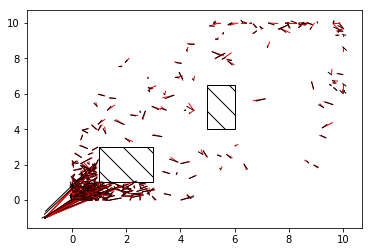

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def Virtualizing(Data, Label, Pred, Obstacles,SampleSize):
    sample_index=np.random.choice(len(Data), SampleSize)
    #print sample_index
    #print Train_Data[sample_index,:2],Train_Label[sample_index,:2]
    fig9 = plt.figure()
    ax9 = fig9.add_subplot(111)
    for i in sample_index:
        plt.plot([Data[i,0],Data[i,0]+Label[i,0]], [Data[i,1],Data[i,1]+Label[i,1]], 'r-',lw=1)
        plt.plot([Data[i,0],Data[i,0]+Pred[i,0]], [Data[i,1],Data[i,1]+Pred[i,1]], 'k-',lw=1)
    for j in range(len(Obstacles)):
        ax9.add_patch(patches.Rectangle((Obstacles[j][0], Obstacles[j][1]),
                                        Obstacles[j][2]-Obstacles[j][0], Obstacles[j][3]-Obstacles[j][1],
                                        hatch='\\', fill=False,linestyle='solid'))
    plt.show()

Virtualizing(Test_Data,Test_Label,Test_Pred,Maze.obstacles,500)

### 2.Weights Extraction Analysis

In [19]:
DNN_DELTA=FullyConnectedDeepNet(6,100,2,4,0.1)
# Train_Data=ReadData(Datapath)
# Train_Label=ReadData(Labelpath)
DNN_DELTA.LoadModel("TransitionModel_DELTA.h5")
for layer in DNN_DELTA.GetModel().layers: 
    g=layer.get_config()
    h=layer.get_weights() 
    print(g) 
    print(h)

{'name': 'sequential_2', 'layers': [{'class_name': 'Dense', 'config': {'name': 'dense_1', 'trainable': True, 'batch_input_shape': (None, 6), 'dtype': 'float32', 'units': 100, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Activation', 'config': {'name': 'activation_1', 'trainable': True, 'activation': 'relu'}}]}
[array([[-1.20051973e-01,  2.73312591e-02, -3.76976818e-01,
        -4.21585417e+00, -3.38754058e-01,  3.79342102e-02,
         1.23219350e-02,  4.04587798e-02, -4.02239591e-01,
         6.03022240e-03,  2.08058327e-01, -9.42350999e-02,
        -2.45788828e-01, -3.62744392e-03,  5.84731027e-02,
         1.24453738e-01, -4.05862361e-0

The weight matrix is input_dim * output_dim, bias is vector with output_dim

The out put format is
target_node_name Activition_function [input_nodel_name weight_target_input]+ ...

We start from the first layer..

### 3. Create New File Layout for MILP

In [21]:
class NetTopology(object):
    def __init__(self,layers,drop_out):
        self.layers=layers
        self.input_dim=layers[0].get_config()[0].get('config').get('input_dim')
        self.num_upper_layers=len(layers)
        self.nodenames=[]
        self.drop_out=drop_out
        layernodename=[]
        for i in range(0, self.input_dim):
            layernodename.append('N0'+str(i))
        layernodename.append('B0')
        self.nodenames.append(layernodename)
        
    def LayerWiseTransform(self,layer,layer_id, lastlayer=False, hiddenstart='N', writefile=False, filehandler=None):
        if not lastlayer:
            input_dim = layer.get_config()[0].get('config').get('input_dim')
            output_dim = layer.get_config()[0].get('config').get('output_dim')
            activation = layer.get_config()[1].get('config').get('activation')
        else:
            input_dim = layer.get_config().get('input_dim')
            output_dim = layer.get_config().get('output_dim')
            activation = layer.get_config().get('activation')
        layernodename=[]
        weights_bias=layer.get_weights()
        weights=weights_bias[0]
        bias=weights_bias[1]
        for i in range(0, output_dim):
            layernodename.append(hiddenstart+str(layer_id)+str(i))
        for i in range(0, output_dim):
            row = [layernodename[i],activation]
            for j in range(0, input_dim):
                row.append(self.nodenames[-1][j])
                row.append(weights[j][i]*self.drop_out)
            row.append(self.nodenames[-1][-1])
            row.append(bias[i])
            if writefile:
                filehandler.write(','.join(map(str, row))+'\n')
            else:
                print(','.join(map(str, row)))
        layernodename.append('B'+str(layer_id))
        self.nodenames.append(layernodename)
        
    def NetTransform(self,hiddenstart='N', writefile=False, filepath=None,overwrite=False):
        filehandler=None
        if writefile:
            fullpath=PathFinder(filepath)
            if overwrite is True:
                filehandler = open(fullpath,'w')
            else:
                filehandler = open(fullpath,'a')
        counter=0
        for i in range(0,self.num_upper_layers):
            if type(self.layers[i]) is not Dropout:
                if (i==self.num_upper_layers-1):
                    self.LayerWiseTransform(self.layers[i],counter+1, True, hiddenstart, writefile, filehandler)
                else:
                    self.LayerWiseTransform(self.layers[i],counter+1, False, hiddenstart, writefile, filehandler)
                counter=counter+1
        if writefile:
            filehandler.close()
        print('Done!')
            
        
        

Topo_DELTA=NetTopology(DNN_DELTA.GetModel().layers,DNN_DELTA.drop_out)
Topo_DELTA.NetTransform('D',True, "Network_MIX.txt",True)
Topo_INJAIL=NetTopology(DNN_INJAIL.GetModel().layers,DNN_INJAIL.drop_out)
Topo_INJAIL.NetTransform('I',True, "Network_MIX.txt",False)
        
    

KeyError: 0

### Notice: 
the output in shape
Output_node_id,Activation_function_name,[Input_node_id, Input_node_weight,]+Bias_id,Bias_weight